# Cycle Time 예측

## 라이브러리 import

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import os, random, time, gc, warnings

from tqdm import tqdm_notebook

import lightgbm as lgbm
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import RFECV


from sklearn.cluster import KMeans

from datetime import datetime

from math import sqrt
import io

warnings.filterwarnings('ignore')

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

%matplotlib inline

## 데이터 전처리

### 데이터 확인

In [27]:
#데이터 불러오기
df=pd.read_csv('D:\\test2\\data-0409-table5-2.csv')
print(df.shape)
df.tail()

(235, 15)


,id,Uid,completed,CycleNumber,MCIn1,MC1PrTime,MCOut1,MCIn2,MC2PrTime,MCOut2,MCIn3,MC3PrTime,MCOut3,Unnamed: 13,Unnamed: 14
230,563,c37b84f4,1,5,43187.99999,23.26,43428.00001,43276.00003,2.99,43488.99996,43498.99999,0.25,43502.99996,True,NaN
231,117,c37b7e02,1,1,0,0.11,43430,0,0.25,43493.00003,43500.99997,0.28,43505.00004,True,NaN
232,413,c37b9987,1,4,0,0.02,43433.99997,43435.99996,0.71,43496.00001,43505.00004,0.48,43513.99998,True,NaN
233,64,c37b9728,1,1,43211.00002,0.75,43437.00004,43441.00001,8.26,43516.99996,43524.99999,4.07,43531.00004,True,NaN
234,id,Uid,completed,CycleNumber,MCIn1,MC1PrTime,MCOut1,MCIn2,MC2PrTime,MCOut2,MCIn3,MC3PrTime,MCOut3,NaN,NaN


In [25]:
#마지막 행 삭제
df_dropped_1 = df.drop([df.index[len(df)-1]])

#Unnamed: 13, Unnamed: 14 열 삭제
drop_column=['Unnamed: 13', 'Unnamed: 14'] 
df_dropped_2=df_dropped_1.drop(drop_column, axis=1, inplace=False)

print(df_dropped_2.shape)
df_dropped_2.head()

(234, 13)


,id,Uid,completed,CycleNumber,MCIn1,MC1PrTime,MCOut1,MCIn2,MC2PrTime,MCOut2,MCIn3,MC3PrTime,MCOut3
0,501,c37b82d7,1,5,36991.99999,0.12,36993.99997,36995.99996,0.11,37000.00002,37009.99996,2.03,37014.00002
1,476,c37b7a6e,1,4,0,2.2,37007.99997,0,3.84,37017,37027.00002,1.27,37031
2,301,c37b83cb,1,3,0,2.36,37031,0,4.1,37044,37048.99997,3.38,37055.00002
3,276,c37b7dfe,1,3,0,4.98,37036.99996,37047.99997,2.93,37058.99999,37066.00003,0.21,37079.00004
4,326,c37b770b,1,3,0,6.87,37044.99999,37053.00003,0.68,37063.99996,37071.99999,0.07,37083.00001


In [21]:
df_dropped_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234 entries, 0 to 233
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           234 non-null    object
 1   Uid          234 non-null    object
 2   completed    234 non-null    object
 3   CycleNumber  234 non-null    object
 4   MCIn1        234 non-null    object
 5   MC1PrTime    234 non-null    object
 6   MCOut1       234 non-null    object
 7   MCIn2        234 non-null    object
 8   MC2PrTime    234 non-null    object
 9   MCOut2       234 non-null    object
 10  MCIn3        234 non-null    object
 11  MC3PrTime    234 non-null    object
 12  MCOut3       234 non-null    object
dtypes: object(13)
memory usage: 25.6+ KB


In [40]:
#열별로 결측값 개수 확인

count1=0

for i in df_dropped_2:
    count2 = 0
    for j in df_dropped_2[i]:
        if j == '0':
            count2+=1
    print('-'*50)
    print(i,"열의 결측값 개수:",count2)
    count1+=count2
    
print('-'*50)
print('전체 결측치:',count1)

--------------------------------------------------
id 열의 결측값 개수: 0
--------------------------------------------------
Uid 열의 결측값 개수: 0
--------------------------------------------------
completed 열의 결측값 개수: 0
--------------------------------------------------
CycleNumber 열의 결측값 개수: 0
--------------------------------------------------
MCIn1 열의 결측값 개수: 104
--------------------------------------------------
MC1PrTime 열의 결측값 개수: 1
--------------------------------------------------
MCOut1 열의 결측값 개수: 26
--------------------------------------------------
MCIn2 열의 결측값 개수: 60
--------------------------------------------------
MC2PrTime 열의 결측값 개수: 0
--------------------------------------------------
MCOut2 열의 결측값 개수: 7
--------------------------------------------------
MCIn3 열의 결측값 개수: 0
--------------------------------------------------
MC3PrTime 열의 결측값 개수: 0
--------------------------------------------------
MCOut3 열의 결측값 개수: 0
--------------------------------------------------
전체 결측치: 198


### 이상치 제거

In [11]:
# 이상치 확인
count=0
for i,j in enumerate(df['MCIn3']):
    if i == 233:
        break
    if df['MCIn3'][i] >= df['MCIn3'][i+1]:
        print('인덱스:',i)
        count+=1
        
print(count)

0


In [4]:
df['MCIn3'][0]

37009.99996

In [6]:
df_sample_1.describe()

,Unnamed: 0,id,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,333.451178,333.451178,0.929293,3.195286,46192.047137,3.893906,50450.811447,46244.107743,3.930000,56340.683502,54165.976432,4.444579,53383.511788
std,187.323048,187.323048,0.256768,1.500758,23133.055054,3.530763,19175.134305,23154.474338,3.811022,9045.370334,13524.960489,4.276012,14885.166018
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000
25%,119.000000,119.000000,1.000000,1.000000,54119.000020,1.280000,54922.999970,54189.999990,1.180000,55760.999960,55448.999970,1.310000,55393.999980
50%,362.000000,362.000000,1.000000,3.000000,56620.999990,2.860000,57159.999990,56813.999960,2.940000,57560.000030,57276.000030,3.330000,57186.999990
75%,489.000000,489.000000,1.000000,4.000000,58925.000020,5.440000,59080.999970,58948.000040,5.090000,59446.999960,58887.000000,6.250000,58829.000030
max,611.000000,611.000000,1.000000,5.000000,61629.999980,17.330000,61405.000040,61583.000030,20.430000,61603.999980,61567.000040,24.200000,61506.000000


In [7]:
df_sample_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   297 non-null    int64  
 1   id           297 non-null    int64  
 2   Uid          297 non-null    object 
 3   completed    297 non-null    int64  
 4   CycleNumber  297 non-null    int64  
 5   MCIn1        297 non-null    float64
 6   MC1Prtime    297 non-null    float64
 7   MCOut1       297 non-null    float64
 8   MCIn2        297 non-null    float64
 9   MC2Prtime    297 non-null    float64
 10  MCOut2       297 non-null    float64
 11  MCIn3        297 non-null    float64
 12  MC3Prtime    297 non-null    float64
 13  MCOut3       297 non-null    float64
dtypes: float64(9), int64(4), object(1)
memory usage: 34.8+ KB


In [8]:
drop_column=['Unnamed: 0', 'Uid' , 'id', 'completed', 'CycleNumber', 'MC1Prtime', 'MC2Prtime', 'MC3Prtime'] 
df_dropped=df_sample_1.drop(drop_column, axis=1, inplace=False)

In [9]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 296
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MCIn1   297 non-null    float64
 1   MCOut1  297 non-null    float64
 2   MCIn2   297 non-null    float64
 3   MCOut2  297 non-null    float64
 4   MCIn3   297 non-null    float64
 5   MCOut3  297 non-null    float64
dtypes: float64(6)
memory usage: 16.2 KB


In [10]:
df_dropped.describe()

,MCIn1,MCOut1,MCIn2,MCOut2,MCIn3,MCOut3
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,46192.047137,50450.811447,46244.107743,56340.683502,54165.976432,53383.511788
std,23133.055054,19175.134305,23154.474338,9045.370334,13524.960489,14885.166018
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54119.000020,54922.999970,54189.999990,55760.999960,55448.999970,55393.999980
50%,56620.999990,57159.999990,56813.999960,57560.000030,57276.000030,57186.999990
75%,58925.000020,59080.999970,58948.000040,59446.999960,58887.000000,58829.000030
max,61629.999980,61405.000040,61583.000030,61603.999980,61567.000040,61506.000000


In [11]:
# 열마다 0이 찍힌 갯수 파악
count1=0
for i in df_dropped:
    count2 = 0
    for j in df_dropped[i]:
        if j == 0:
            count2+=1   
    count1+=count2
    print(count2)
print('전체 결측치:',count1)

59
37
59
7
17
21
전체 결측치: 200


In [12]:
# m1iN열을 기준으로 오름차순 정렬
df_dropped.sort_values(by=['MCOut2'], axis=0, ascending=True, inplace = True)

#인덱스 설정
#df_dropped_setIdx=df_dropped.set_index('index')
#df_dropped_setIdx.head()

#인덱스 리셋
df_dropped_resetIdx = df_dropped.reset_index(drop=True)
df_dropped_resetIdx

,MCIn1,MCOut1,MCIn2,MCOut2,MCIn3,MCOut3
0,54119.00002,54163.99999,54165.99997,0.00000,54267.00002,54374.00003
1,56992.00003,56996.00001,0.00000,0.00000,57105.00000,57126.00004
2,0.00000,54576.00003,0.00000,0.00000,54657.00003,54679.99997
3,55206.99996,55214.00001,55215.99999,0.00000,55338.99998,55376.00001
4,57738.00001,57743.99997,0.00000,0.00000,57851.99997,57886.00001
5,57201.99998,57228.99998,57231.99996,0.00000,57360.00001,57373.00001
6,61597.00002,0.00000,0.00000,0.00000,0.00000,0.00000
7,53776.99996,0.00000,53789.99996,53843.99996,53854.99998,53903.00002
8,53812.99999,53837.00001,0.00000,53916.00002,53923.99997,53941.00003
9,53961.99998,53839.99999,53842.99997,53926.00004,54127.99996,54137.99998


In [13]:
# 행을 돌면서 m1in<m1out<m2in<m2out<m3in<m3out 구조를 따르지 않는 데이터 값 삭제
count = 0
m1inout = 0
m1m2 = 0
m2inout = 0
m2m3 = 0
m3inout = 0

for i, j in enumerate(df_dropped_resetIdx['MCIn1']):
    # 왼쪽 0 오른쪽값 살리기
    # m1in, m1out 비교
    if df_dropped_resetIdx.iloc[i, 1] < df_dropped_resetIdx.iloc[i, 0]:
        if (df_dropped_resetIdx.iloc[i, 1] != 0) & (df_dropped_resetIdx.iloc[i, 0] != 0):
            df_dropped_resetIdx.iloc[i, 0] = 0
            print('확인바람: ',i , '행 m1in, m1out')
            count+=1
            m1inout+=1
    # m1out, m2in 비교
    if df_dropped_resetIdx.iloc[i, 2] < df_dropped_resetIdx.iloc[i, 1]:
        if (df_dropped_resetIdx.iloc[i, 2] != 0) & (df_dropped_resetIdx.iloc[i, 1] != 0):
            df_dropped_resetIdx.iloc[i, 1] = 0
            print('확인바람: ',i , '행 m1out, m2in')
            count+=1
            m1m2 += 1
    # m2in, m2out 비교
    if df_dropped_resetIdx.iloc[i, 3] < df_dropped_resetIdx.iloc[i, 2]:
        if (df_dropped_resetIdx.iloc[i, 3] != 0) & (df_dropped_resetIdx.iloc[i, 2] != 0):
            df_dropped_resetIdx.iloc[i, 2] = 0
            print('확인바람: ',i , '행 m2in, m2out')
            count+=1
            m2inout += 1
    # m2out, m3in 비교
    if df_dropped_resetIdx.iloc[i, 4] < df_dropped_resetIdx.iloc[i, 3]:
        if (df_dropped_resetIdx.iloc[i, 4] != 0) & (df_dropped_resetIdx.iloc[i, 3] != 0):
            df_dropped_resetIdx.iloc[i, 3] = 0
            print('확인바람: ',i , '행 m2out, m3in')
            count+=1
            m2m3 +=1
    # m3in, m3out 비교
    if df_dropped_resetIdx.iloc[i, 5] < df_dropped_resetIdx.iloc[i, 4]:
        if (df_dropped_resetIdx.iloc[i, 5] != 0) & (df_dropped_resetIdx.iloc[i, 4] != 0):
            df_dropped_resetIdx.iloc[i, 4] = 0
            print('확인바람: ',i , '행 m3in, m3out')
            count+=1
            m3inout +=1

print('이상값:',count,', m1inout:',m1inout,", m1m2:",m1m2,", m2inout:",m2inout,", m2m3",m2m3,", m3inout:",m3inout)
df_dropped_resetIdx.head(10)

확인바람:  9 행 m1in, m1out
확인바람:  14 행 m2in, m2out
확인바람:  15 행 m2out, m3in
확인바람:  18 행 m1in, m1out
확인바람:  18 행 m2out, m3in
확인바람:  23 행 m2out, m3in
확인바람:  29 행 m2out, m3in
확인바람:  30 행 m1in, m1out
확인바람:  31 행 m2in, m2out
확인바람:  32 행 m1in, m1out
확인바람:  33 행 m1out, m2in
확인바람:  35 행 m1in, m1out
확인바람:  37 행 m2in, m2out
확인바람:  40 행 m2out, m3in
확인바람:  41 행 m1in, m1out
확인바람:  41 행 m2out, m3in
확인바람:  42 행 m1out, m2in
확인바람:  44 행 m2out, m3in
확인바람:  45 행 m1out, m2in
확인바람:  51 행 m1in, m1out
확인바람:  55 행 m1out, m2in
확인바람:  57 행 m1out, m2in
확인바람:  57 행 m2out, m3in
확인바람:  66 행 m1out, m2in
확인바람:  69 행 m2out, m3in
확인바람:  83 행 m1in, m1out
확인바람:  87 행 m1out, m2in
확인바람:  90 행 m1out, m2in
확인바람:  91 행 m1out, m2in
확인바람:  99 행 m1out, m2in
확인바람:  102 행 m1out, m2in
확인바람:  110 행 m1out, m2in
확인바람:  111 행 m1in, m1out
확인바람:  111 행 m1out, m2in
확인바람:  112 행 m1out, m2in
확인바람:  115 행 m1out, m2in
확인바람:  117 행 m2in, m2out
확인바람:  120 행 m1in, m1out
확인바람:  120 행 m2in, m2out
확인바람:  121 행 m1out, m2in
확인바람:  124 행 m1in, m1out
확인바람: 

,MCIn1,MCOut1,MCIn2,MCOut2,MCIn3,MCOut3
0,54119.00002,54163.99999,54165.99997,0.00000,54267.00002,54374.00003
1,56992.00003,56996.00001,0.00000,0.00000,57105.00000,57126.00004
2,0.00000,54576.00003,0.00000,0.00000,54657.00003,54679.99997
3,55206.99996,55214.00001,55215.99999,0.00000,55338.99998,55376.00001
4,57738.00001,57743.99997,0.00000,0.00000,57851.99997,57886.00001
5,57201.99998,57228.99998,57231.99996,0.00000,57360.00001,57373.00001
6,61597.00002,0.00000,0.00000,0.00000,0.00000,0.00000
7,53776.99996,0.00000,53789.99996,53843.99996,53854.99998,53903.00002
8,53812.99999,53837.00001,0.00000,53916.00002,53923.99997,53941.00003
9,0.00000,53839.99999,53842.99997,53926.00004,54127.99996,54137.99998


In [14]:
# 행을 돌면서 m1in<m1out<m2in<m2out<m3in<m3out 구조를 따르지 않는 데이터 값 삭제
count = 0
m1inout = 0
m1m2 = 0
m2inout = 0
m2m3 = 0
m3inout = 0

for i, j in enumerate(df_dropped_resetIdx['MCIn1']):
    # 왼쪽 0 오른쪽값 살리기
    # m1in, m1out 비교
    if df_dropped_resetIdx.iloc[i, 1] < df_dropped_resetIdx.iloc[i, 0]:
        if (df_dropped_resetIdx.iloc[i, 1] != 0) & (df_dropped_resetIdx.iloc[i, 0] != 0):
            df_dropped_resetIdx.iloc[i, 0] = 0
            print('확인바람: ',i , '행 m1in, m1out')
            count+=1
            m1inout+=1
    # m1out, m2in 비교
    if df_dropped_resetIdx.iloc[i, 2] < df_dropped_resetIdx.iloc[i, 1]:
        if (df_dropped_resetIdx.iloc[i, 2] != 0) & (df_dropped_resetIdx.iloc[i, 1] != 0):
            df_dropped_resetIdx.iloc[i, 1] = 0
            print('확인바람: ',i , '행 m1out, m2in')
            count+=1
            m1m2 += 1
    # m2in, m2out 비교
    if df_dropped_resetIdx.iloc[i, 3] < df_dropped_resetIdx.iloc[i, 2]:
        if (df_dropped_resetIdx.iloc[i, 3] != 0) & (df_dropped_resetIdx.iloc[i, 2] != 0):
            df_dropped_resetIdx.iloc[i, 2] = 0
            print('확인바람: ',i , '행 m2in, m2out')
            count+=1
            m2inout += 1
    # m2out, m3in 비교
    if df_dropped_resetIdx.iloc[i, 4] < df_dropped_resetIdx.iloc[i, 3]:
        if (df_dropped_resetIdx.iloc[i, 4] != 0) & (df_dropped_resetIdx.iloc[i, 3] != 0):
            df_dropped_resetIdx.iloc[i, 3] = 0
            print('확인바람: ',i , '행 m2out, m3in')
            count+=1
            m2m3 +=1
    # m3in, m3out 비교
    if df_dropped_resetIdx.iloc[i, 5] < df_dropped_resetIdx.iloc[i, 4]:
        if (df_dropped_resetIdx.iloc[i, 5] != 0) & (df_dropped_resetIdx.iloc[i, 4] != 0):
            df_dropped_resetIdx.iloc[i, 4] = 0
            print('확인바람: ',i , '행 m3in, m3out')
            count+=1
            m3inout +=1

print('이상값:',count,', m1inout:',m1inout,", m1m2:",m1m2,", m2inout:",m2inout,", m2m3",m2m3,", m3inout:",m3inout)
df_dropped_resetIdx.head(10)

이상값: 0 , m1inout: 0 , m1m2: 0 , m2inout: 0 , m2m3 0 , m3inout: 0


,MCIn1,MCOut1,MCIn2,MCOut2,MCIn3,MCOut3
0,54119.00002,54163.99999,54165.99997,0.00000,54267.00002,54374.00003
1,56992.00003,56996.00001,0.00000,0.00000,57105.00000,57126.00004
2,0.00000,54576.00003,0.00000,0.00000,54657.00003,54679.99997
3,55206.99996,55214.00001,55215.99999,0.00000,55338.99998,55376.00001
4,57738.00001,57743.99997,0.00000,0.00000,57851.99997,57886.00001
5,57201.99998,57228.99998,57231.99996,0.00000,57360.00001,57373.00001
6,61597.00002,0.00000,0.00000,0.00000,0.00000,0.00000
7,53776.99996,0.00000,53789.99996,53843.99996,53854.99998,53903.00002
8,53812.99999,53837.00001,0.00000,53916.00002,53923.99997,53941.00003
9,0.00000,53839.99999,53842.99997,53926.00004,54127.99996,54137.99998


In [15]:
# 열마다 0이 찍힌 갯수 파악
count1=0
for i in df_dropped_resetIdx:
    count2 = 0
    for j in df_dropped_resetIdx[i]:
        if j == 0:
            count2+=1   
    count1+=count2
    print(count2)
print('전체 결측치:',count1)

99
80
73
25
17
21
전체 결측치: 315


In [16]:
# m1iN열을 기준으로 오름차순 정렬
df_dropped_resetIdx.sort_values(by=['MCIn3'], axis=0, ascending=True)

,MCIn1,MCOut1,MCIn2,MCOut2,MCIn3,MCOut3
296,0.00000,61247.00002,61547.00000,61603.99998,0.00000,0.00000
279,61605.99996,0.00000,61432.00004,61473.00004,0.00000,0.00000
280,0.00000,61303.00000,61436.00002,61479.00000,0.00000,0.00000
281,0.00000,61311.00004,61440.99998,61483.99997,0.00000,0.00000
282,0.00000,61313.00003,61452.00000,61487.00004,0.00000,0.00000
283,0.00000,61319.99998,61460.00004,61495.99998,0.00000,0.00000
284,61622.00004,0.00000,61469.99997,61505.00001,0.00000,0.00000
285,61629.99998,0.00000,61473.00004,61515.00003,0.00000,0.00000
286,0.00000,61368.00002,61488.00003,61521.99998,0.00000,0.00000
277,0.00000,61276.00000,61425.00000,61462.00002,0.00000,0.00000


In [17]:
# m1in & m1out 둘 다 찍힌 인덱스
df_idx_1 = df_dropped_resetIdx[(df_dropped_resetIdx['MCIn1'] != 0 ) & (df_dropped_resetIdx['MCOut1'] != 0 )].index
# m1out & m2in 둘 다 찍힌 인덱스
df_idx_2 = df_dropped_resetIdx[(df_dropped_resetIdx['MCOut1'] != 0 ) & (df_dropped_resetIdx['MCIn2'] != 0 )].index
# m2in & m2out 둘 다 찍힌 인덱스
df_idx_3 = df_dropped_resetIdx[(df_dropped_resetIdx['MCIn2'] != 0 ) & (df_dropped_resetIdx['MCOut2'] != 0 )].index
# m2out & m3in 둘 다 찍힌 인덱스
df_idx_4 = df_dropped_resetIdx[(df_dropped_resetIdx['MCOut2'] != 0 ) & (df_dropped_resetIdx['MCIn3'] != 0 )].index
# m3in & m3out 둘 다 찍힌 인덱스
df_idx_5 = df_dropped_resetIdx[(df_dropped_resetIdx['MCIn3'] != 0 ) & (df_dropped_resetIdx['MCOut3'] != 0 )].index

print(len(df_idx_1),len(df_idx_2),len(df_idx_3),len(df_idx_4),len(df_idx_5))

134 154 207 256 276


In [18]:
# m1in ~ m1out 시간 차이 구하기
df_sample_2 = df_dropped_resetIdx.loc[df_idx_1]
df_sample_2['difference_1'] = df_sample_2['MCOut1'] - df_sample_2['MCIn1']
# m1out ~ m2in 시간 차이 구하기
df_sample_3 = df_dropped_resetIdx.loc[df_idx_2]
df_sample_3['difference_2'] = df_sample_3['MCIn2'] - df_sample_3['MCOut1']
# m2in ~ m2out 시간 차이 구하기
df_sample_4 = df_dropped_resetIdx.loc[df_idx_3]
df_sample_4['difference_3'] = df_sample_4['MCOut2'] - df_sample_4['MCIn2']
# m2out ~ m3in 시간 차이 구하기
df_sample_5 = df_dropped_resetIdx.loc[df_idx_4]
df_sample_5['difference_4'] = df_sample_5['MCIn3'] - df_sample_5['MCOut2']
# m3in ~ m3out 시간 차이 구하기
df_sample_6 = df_dropped_resetIdx.loc[df_idx_5]
df_sample_6['difference_5'] = df_sample_6['MCOut3'] - df_sample_6['MCIn3']

print(df_sample_2['difference_1'].mean(),'---', df_sample_3['difference_2'].mean(),'---', df_sample_4['difference_3'].mean()
     ,'---',df_sample_5['difference_4'].mean(),'---', df_sample_6['difference_5'].mean())

115.71641843283545 --- 47.389607532467984 --- 126.51690898550673 --- 21.82812609375037 --- 49.75362532608668


<AxesSubplot:>

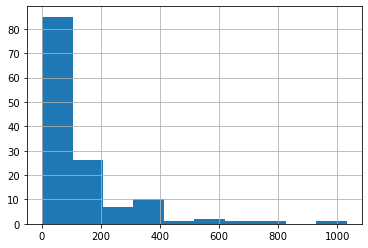

In [19]:
df_sample_2['difference_1'].hist()

<AxesSubplot:>

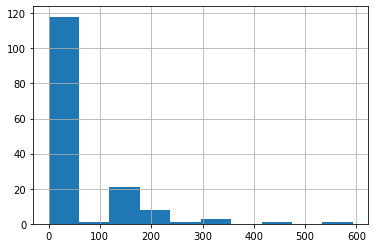

In [20]:
df_sample_3['difference_2'].hist()

<AxesSubplot:>

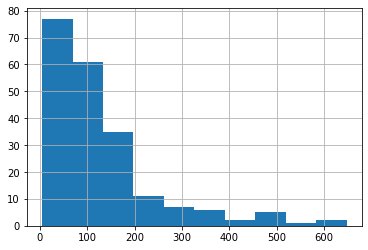

In [21]:
df_sample_4['difference_3'].hist()

<AxesSubplot:>

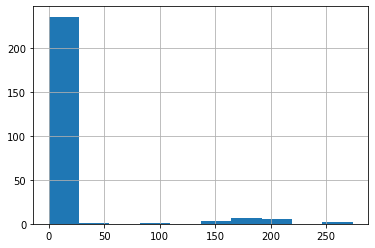

In [22]:
df_sample_5['difference_4'].hist()

<AxesSubplot:>

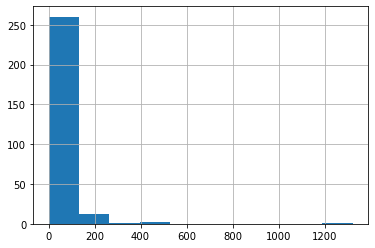

In [23]:
df_sample_6['difference_5'].hist()

In [24]:
'''
# m1in ~ m1out 시간 차이 중에서 너무 큰 값은 이상치로 판단 -> 제거
for i, j in enumerate(df_dropped_resetIdx['m1iN']):
    # m1in, m1out 비교
    if (df_dropped_resetIdx.iloc[i, 1] - df_dropped_resetIdx.iloc[i, 0])>600:
        df_dropped_resetIdx.iloc[i, 1] = 0
        
# m1in & m1out 둘 다 찍힌 인덱스
df_idx_1 = df_dropped_resetIdx[(df_dropped_resetIdx['m1iN'] != 0 ) & (df_dropped_resetIdx['m1ouT'] != 0 )].index

# m1in ~ m1out 시간 차이 구하기
df_sample_2 = df_dropped_resetIdx.loc[df_idx_1]
df_sample_2['difference_1'] = df_sample_2['m1ouT'] - df_sample_2['m1iN']

df_sample_2['difference_1'].hist()
'''

"\n# m1in ~ m1out 시간 차이 중에서 너무 큰 값은 이상치로 판단 -> 제거\nfor i, j in enumerate(df_dropped_resetIdx['m1iN']):\n    # m1in, m1out 비교\n    if (df_dropped_resetIdx.iloc[i, 1] - df_dropped_resetIdx.iloc[i, 0])>600:\n        df_dropped_resetIdx.iloc[i, 1] = 0\n        \n# m1in & m1out 둘 다 찍힌 인덱스\ndf_idx_1 = df_dropped_resetIdx[(df_dropped_resetIdx['m1iN'] != 0 ) & (df_dropped_resetIdx['m1ouT'] != 0 )].index\n\n# m1in ~ m1out 시간 차이 구하기\ndf_sample_2 = df_dropped_resetIdx.loc[df_idx_1]\ndf_sample_2['difference_1'] = df_sample_2['m1ouT'] - df_sample_2['m1iN']\n\ndf_sample_2['difference_1'].hist()\n"

### 결측치 대체

In [25]:
print(df_sample_2['difference_1'].describe(),'\n', df_sample_3['difference_2'].describe(),'\n'
     ,df_sample_4['difference_3'].describe(),'\n',df_sample_5['difference_4'].describe(),'\n'
     ,df_sample_6['difference_5'].describe())

count     134.000000
mean      115.716418
std       169.856846
min         1.000000
25%         8.500028
50%        28.499990
75%       178.750005
max      1030.999960
Name: difference_1, dtype: float64 
 count    154.000000
mean      47.389608
std       93.802485
min        0.000000
25%        1.999990
50%        2.999980
75%        5.750053
max      593.000010
Name: difference_2, dtype: float64 
 count    207.000000
mean     126.516909
std      117.825517
min        5.000050
25%       44.999975
50%       95.999990
75%      155.500045
max      647.000000
Name: difference_3, dtype: float64 
 count    256.000000
mean      21.828126
std       47.752233
min        0.000000
25%        7.000050
50%        9.000030
75%       10.000030
max      273.999980
Name: difference_4, dtype: float64 
 count     276.000000
mean       49.753625
std        96.069582
min         0.000000
25%        10.000027
50%        26.500005
75%        63.250005
max      1323.000000
Name: difference_5, dtype: float64


In [26]:
#rand_norm2

In [33]:
# 행을 돌면서 결측치를 평균 값으로 대체

# 난수 생성
mu1, sigma1 = df_sample_2['difference_1'].mean(), (df_sample_2['difference_1'].std())/10
rand_norm1 = np.random.normal(mu1, sigma1, size=600)

mu2, sigma2 = df_sample_3['difference_2'].mean(), (df_sample_3['difference_2'].std())/10
rand_norm2 = np.random.normal(mu2, sigma2, size=600)

mu3, sigma3 = df_sample_4['difference_3'].mean(), (df_sample_4['difference_3'].std())/10
rand_norm3 = np.random.normal(mu3, sigma3, size=600)

mu4, sigma4 = df_sample_5['difference_4'].mean(), (df_sample_5['difference_4'].std())/10
rand_norm4 = np.random.normal(mu4, sigma4, size=600)

mu5, sigma5 = df_sample_6['difference_5'].mean(), (df_sample_6['difference_5'].std())/10
rand_norm5 = np.random.normal(mu5, sigma5, size=600)



for i, j in enumerate(df_dropped_resetIdx['MCIn1']):
    # m1in이 0이고 m1out이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 0] == 0:
        if df_dropped_resetIdx.iloc[i, 1] != 0:
            #rand_norm1 = np.random.normal(mu1, sigma1, size=1)
            df_dropped_resetIdx.iloc[i, 0] = df_dropped_resetIdx.iloc[i, 1] - round(rand_norm1[i])
    # m1out이 0이고 m2in이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 1] == 0:
        if df_dropped_resetIdx.iloc[i, 2] != 0:
            #rand_norm2 = np.random.normal(mu2, sigma2, size=1)
            df_dropped_resetIdx.iloc[i, 1] = df_dropped_resetIdx.iloc[i, 2] - round(rand_norm2[i])
    # m2in이 0이고 m2out이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 2] == 0:
        if df_dropped_resetIdx.iloc[i, 3] != 0:
            #rand_norm3 = np.random.normal(mu3, sigma3, size=1)
            df_dropped_resetIdx.iloc[i, 2] = df_dropped_resetIdx.iloc[i, 3] - round(rand_norm3[i])
    # m2out이 0이고 m3in이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 3] == 0:
        if df_dropped_resetIdx.iloc[i, 4] != 0:
            #rand_norm4 = np.random.normal(mu4, sigma4, size=1)
            df_dropped_resetIdx.iloc[i, 3] = df_dropped_resetIdx.iloc[i, 4] - round(rand_norm4[i])
    # m3in이 0이고 m3out이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 4] == 0:
        if df_dropped_resetIdx.iloc[i, 5] != 0:
            #rand_norm5 = np.random.normal(mu5, sigma5, size=1)
            df_dropped_resetIdx.iloc[i, 4] = df_dropped_resetIdx.iloc[i, 5] - round(rand_norm5[i])

# 4번정도 돌리는게 적당 그 후로는 값이 안바뀜            
df_dropped_resetIdx

,MCIn1,MCOut1,MCIn2,MCOut2,MCIn3,MCOut3
0,54119.00002,54163.99999,54165.99997,54244.00002,54267.00002,54374.00003
1,56799.00000,56926.00000,56964.00000,57087.00000,57105.00000,57126.00004
2,54323.00003,54451.00003,54502.00003,54640.00003,54657.00003,54679.99997
3,55206.99996,55214.00001,55215.99999,55312.99998,55338.99998,55376.00001
4,57559.99997,57677.99997,57713.99997,57829.99997,57851.99997,57886.00001
5,57201.99998,57228.99998,57231.99996,57332.00001,57360.00001,57373.00001
6,61597.00002,0.00000,0.00000,0.00000,0.00000,0.00000
7,53661.99996,53769.99996,53789.99996,53843.99996,53854.99998,53903.00002
8,53626.00002,53738.00002,53788.00002,53916.00002,53923.99997,53941.00003
9,53726.99999,53839.99999,53842.99997,53926.00004,54127.99996,54137.99998


In [34]:
# 행을 돌면서 m1in<m1out<m2in<m2out<m3in<m3out 구조를 따르지 않는 데이터 값 삭제
count = 0
m1inout = 0
m1m2 = 0
m2inout = 0
m2m3 = 0
m3inout = 0

for i, j in enumerate(df_dropped_resetIdx['MCIn1']):
    # 왼쪽 0 오른쪽값 살리기
    # m1in, m1out 비교
    if df_dropped_resetIdx.iloc[i, 1] < df_dropped_resetIdx.iloc[i, 0]:
        if (df_dropped_resetIdx.iloc[i, 1] != 0) & (df_dropped_resetIdx.iloc[i, 0] != 0):
            df_dropped_resetIdx.iloc[i, 0] = 0
            print('확인바람: ',i , '행 m1in, m1out')
            count+=1
            m1inout+=1
    # m1out, m2in 비교
    if df_dropped_resetIdx.iloc[i, 2] < df_dropped_resetIdx.iloc[i, 1]:
        if (df_dropped_resetIdx.iloc[i, 2] != 0) & (df_dropped_resetIdx.iloc[i, 1] != 0):
            df_dropped_resetIdx.iloc[i, 1] = 0
            print('확인바람: ',i , '행 m1out, m2in')
            count+=1
            m1m2 += 1
    # m2in, m2out 비교
    if df_dropped_resetIdx.iloc[i, 3] < df_dropped_resetIdx.iloc[i, 2]:
        if (df_dropped_resetIdx.iloc[i, 3] != 0) & (df_dropped_resetIdx.iloc[i, 2] != 0):
            df_dropped_resetIdx.iloc[i, 2] = 0
            print('확인바람: ',i , '행 m2in, m2out')
            count+=1
            m2inout += 1
    # m2out, m3in 비교
    if df_dropped_resetIdx.iloc[i, 4] < df_dropped_resetIdx.iloc[i, 3]:
        if (df_dropped_resetIdx.iloc[i, 4] != 0) & (df_dropped_resetIdx.iloc[i, 3] != 0):
            df_dropped_resetIdx.iloc[i, 3] = 0
            print('확인바람: ',i , '행 m2out, m3in')
            count+=1
            m2m3 +=1
    # m3in, m3out 비교
    if df_dropped_resetIdx.iloc[i, 5] < df_dropped_resetIdx.iloc[i, 4]:
        if (df_dropped_resetIdx.iloc[i, 5] != 0) & (df_dropped_resetIdx.iloc[i, 4] != 0):
            df_dropped_resetIdx.iloc[i, 4] = 0
            print('확인바람: ',i , '행 m3in, m3out')
            count+=1
            m3inout +=1

print('이상값:',count,', m1inout:',m1inout,", m1m2:",m1m2,", m2inout:",m2inout,", m2m3",m2m3,", m3inout:",m3inout)
df_dropped_resetIdx.head(10)

이상값: 0 , m1inout: 0 , m1m2: 0 , m2inout: 0 , m2m3 0 , m3inout: 0


,MCIn1,MCOut1,MCIn2,MCOut2,MCIn3,MCOut3
0,54119.00002,54163.99999,54165.99997,54244.00002,54267.00002,54374.00003
1,56799.00000,56926.00000,56964.00000,57087.00000,57105.00000,57126.00004
2,54323.00003,54451.00003,54502.00003,54640.00003,54657.00003,54679.99997
3,55206.99996,55214.00001,55215.99999,55312.99998,55338.99998,55376.00001
4,57559.99997,57677.99997,57713.99997,57829.99997,57851.99997,57886.00001
5,57201.99998,57228.99998,57231.99996,57332.00001,57360.00001,57373.00001
6,61597.00002,0.00000,0.00000,0.00000,0.00000,0.00000
7,53661.99996,53769.99996,53789.99996,53843.99996,53854.99998,53903.00002
8,53626.00002,53738.00002,53788.00002,53916.00002,53923.99997,53941.00003
9,53726.99999,53839.99999,53842.99997,53926.00004,54127.99996,54137.99998


In [40]:
# 행을 돌면서 결측치를 평균 값으로 대체 -> 역순으로 실행
for i, j in enumerate(df_dropped_resetIdx['MCIn1']):
    # m1in이 0이고 m1out이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 5] == 0:
        if df_dropped_resetIdx.iloc[i, 4] != 0:
            df_dropped_resetIdx.iloc[i, 5] = df_dropped_resetIdx.iloc[i, 4] + round(rand_norm5[i+200])
    # m1out이 0이고 m2in이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 4] == 0:
        if df_dropped_resetIdx.iloc[i, 3] != 0:
            df_dropped_resetIdx.iloc[i, 4] = df_dropped_resetIdx.iloc[i, 3] + round(rand_norm4[i+200])
    # m1in이 0이고 m1out이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 3] == 0:
        if df_dropped_resetIdx.iloc[i, 2] != 0:
            df_dropped_resetIdx.iloc[i, 3] = df_dropped_resetIdx.iloc[i, 2] + round(rand_norm3[i+200])
    # m1in이 0이고 m1out이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 2] == 0:
        if df_dropped_resetIdx.iloc[i, 1] != 0:
            df_dropped_resetIdx.iloc[i, 2] = df_dropped_resetIdx.iloc[i, 1] + round(rand_norm2[i+200])
    # m1in이 0이고 m1out이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 1] == 0:
        if df_dropped_resetIdx.iloc[i, 0] != 0:
            df_dropped_resetIdx.iloc[i, 1] = df_dropped_resetIdx.iloc[i, 0] + round(rand_norm1[i+200])

# 4번정도 돌리는게 적당 그 후로는 값이 안바뀜            
df_dropped_resetIdx
df_completed = df_dropped_resetIdx.sort_values(by=['MCIn1'], axis=0, ascending=True)
#df_completed.to_pickle("df_completed.pkl")
#df_completed.to_csv("df_completed.csv")
df_completed

,MCIn1,MCOut1,MCIn2,MCOut2,MCIn3,MCOut3
8,53626.00002,53738.00002,53788.00002,53916.00002,53923.99997,53941.00003
10,53631.99997,53764.99997,53799.99997,53936.99997,53946.00000,53950.99997
23,53659.00002,53791.00002,53849.00002,53970.00002,53997.00002,54213.00002
7,53661.99996,53769.99996,53789.99996,53843.99996,53854.99998,53903.00002
18,53691.99997,53801.99997,53803.99996,53847.00002,53875.00002,54108.00000
13,53698.99996,53844.99996,53897.99996,54000.00000,54011.00002,54014.99999
9,53726.99999,53839.99999,53842.99997,53926.00004,54127.99996,54137.99998
16,53738.00001,53872.00001,53924.00001,54052.00001,54064.00002,54064.00002
11,53752.00003,53874.00003,53878.00000,53954.00004,53964.99996,53974.99999
17,53768.99997,53906.99997,53963.99997,54061.00004,54070.99998,54073.99996


In [41]:
# 행을 돌면서 m1in<m1out<m2in<m2out<m3in<m3out 구조를 따르지 않는 데이터 값 삭제
count = 0
m1inout = 0
m1m2 = 0
m2inout = 0
m2m3 = 0
m3inout = 0

for i, j in enumerate(df_dropped_resetIdx['MCIn1']):
    # 왼쪽 0 오른쪽값 살리기
    # m1in, m1out 비교
    if df_dropped_resetIdx.iloc[i, 1] < df_dropped_resetIdx.iloc[i, 0]:
        if (df_dropped_resetIdx.iloc[i, 1] != 0) & (df_dropped_resetIdx.iloc[i, 0] != 0):
            df_dropped_resetIdx.iloc[i, 0] = 0
            print('확인바람: ',i , '행 m1in, m1out')
            count+=1
            m1inout+=1
    # m1out, m2in 비교
    if df_dropped_resetIdx.iloc[i, 2] < df_dropped_resetIdx.iloc[i, 1]:
        if (df_dropped_resetIdx.iloc[i, 2] != 0) & (df_dropped_resetIdx.iloc[i, 1] != 0):
            df_dropped_resetIdx.iloc[i, 1] = 0
            print('확인바람: ',i , '행 m1out, m2in')
            count+=1
            m1m2 += 1
    # m2in, m2out 비교
    if df_dropped_resetIdx.iloc[i, 3] < df_dropped_resetIdx.iloc[i, 2]:
        if (df_dropped_resetIdx.iloc[i, 3] != 0) & (df_dropped_resetIdx.iloc[i, 2] != 0):
            df_dropped_resetIdx.iloc[i, 2] = 0
            print('확인바람: ',i , '행 m2in, m2out')
            count+=1
            m2inout += 1
    # m2out, m3in 비교
    if df_dropped_resetIdx.iloc[i, 4] < df_dropped_resetIdx.iloc[i, 3]:
        if (df_dropped_resetIdx.iloc[i, 4] != 0) & (df_dropped_resetIdx.iloc[i, 3] != 0):
            df_dropped_resetIdx.iloc[i, 3] = 0
            print('확인바람: ',i , '행 m2out, m3in')
            count+=1
            m2m3 +=1
    # m3in, m3out 비교
    if df_dropped_resetIdx.iloc[i, 5] < df_dropped_resetIdx.iloc[i, 4]:
        if (df_dropped_resetIdx.iloc[i, 5] != 0) & (df_dropped_resetIdx.iloc[i, 4] != 0):
            df_dropped_resetIdx.iloc[i, 4] = 0
            print('확인바람: ',i , '행 m3in, m3out')
            count+=1
            m3inout +=1

print('이상값:',count,', m1inout:',m1inout,", m1m2:",m1m2,", m2inout:",m2inout,", m2m3",m2m3,", m3inout:",m3inout)
df_dropped_resetIdx.tail(10)

이상값: 0 , m1inout: 0 , m1m2: 0 , m2inout: 0 , m2m3 0 , m3inout: 0


,MCIn1,MCOut1,MCIn2,MCOut2,MCIn3,MCOut3
287,61248.00000,61371.00000,61490.00002,61523.99997,61533.99999,61576.99999
288,60907.00002,61002.00002,61044.00002,61532.00001,61557.00001,61620.00001
289,61271.99998,61386.99998,61506.00000,61540.00004,61547.99999,61582.99999
290,61337.00003,61471.00003,61515.00003,61542.00003,61566.00003,61617.00003
291,61262.99999,61370.99999,61424.99999,61547.99999,61568.99999,61597.99999
292,61132.00004,61243.00004,61529.00003,61562.99998,61567.00004,61607.00004
293,61181.99998,61265.99998,61562.99998,61581.00004,61604.00004,61650.00004
294,61390.99996,61522.99996,61565.99996,61587.99999,61612.99999,61653.99999
295,60998.00004,61136.00004,61583.00003,61597.00002,61616.00002,61673.00002
296,61134.00002,61247.00002,61547.00000,61603.99998,61627.99998,61682.99998


### 데이터 가공

In [45]:
# df_completed 사용, step: 100
totalTime = []
for i in range(int(min(df_completed['MCIn1'])),int(max(df_completed['MCOut3']))+1,200): #m1in min 시간과 m3out max 시간
    totalTime.append(i)
len(totalTime), len(df_completed)

(42, 297)

In [46]:
# 데이터 받고 돌려볼 로직
#12시31분 -> 12시50분
#timeData = 51534
#m1_buffer , m1m2, m2buffer, m2m3, m3buffer = 0, 0, 0, 0, 0

list2=[]

m1_buffer_list =[]
m1m2_list =[]
m2buffer_list =[]
m2m3_list =[]
m3buffer_list =[]
#ct_list=[]

for timeData in totalTime:
    m1_buffer , m1m2, m2buffer, m2m3, m3buffer = 0, 0, 0, 0, 0
    ct_idx=0
    #ct=0
    print('--------------------------------------------------------',timeData)
    for i, j in enumerate(df_completed['MCIn1']):
        if (timeData >= df_completed.loc[[i],['MCIn1']]).bool() & (timeData <= df_completed.loc[[i],['MCOut1']]).bool():
            m1_buffer +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['MCOut1']]).bool() & (timeData <= df_completed.loc[[i],['MCIn2']]).bool():
            m1m2 +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['MCIn2']]).bool() & (timeData <= df_completed.loc[[i],['MCOut2']]).bool():
            m2buffer +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['MCOut2']]).bool() & (timeData <= df_completed.loc[[i],['MCIn3']]).bool():
            m2m3 +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['MCIn3']]).bool() & (timeData <= df_completed.loc[[i],['MCOut3']]).bool():
            m3buffer +=1
            ct_idx=i
    
    #ct = df_completed.loc[[ct_idx],['m3ouT']] - df_completed.loc[[ct_idx],['m1iN']]
    #ct = df_completed.iloc[ct_idx+1, 5] - df_completed.iloc[ct_idx+1, 0] #자리위치로 연산

    m1_buffer_list.append(m1_buffer)
    m1m2_list.append(m1m2)
    m2buffer_list.append(m2buffer)
    m2m3_list.append(m2m3)
    m3buffer_list.append(m3buffer)
    #ct_list.append(ct)
    
df_3 = pd.DataFrame({'m1_buffer':m1_buffer_list,
                     'm1m2':m1m2_list,
                     'm2buffer':m2buffer_list,
                     'm2m3':m2m3_list,
                     'm3buffer':m3buffer_list,
                     #'CycleTime':ct_list
                      })

-------------------------------------------------------- 53626
-------------------------------------------------------- 53826
-------------------------------------------------------- 54026
-------------------------------------------------------- 54226
-------------------------------------------------------- 54426
-------------------------------------------------------- 54626
-------------------------------------------------------- 54826
-------------------------------------------------------- 55026
-------------------------------------------------------- 55226
-------------------------------------------------------- 55426
-------------------------------------------------------- 55626
-------------------------------------------------------- 55826
-------------------------------------------------------- 56026
-------------------------------------------------------- 56226
-------------------------------------------------------- 56426
-------------------------------------------------------

In [154]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
df_3['CycleTime'] = df_completed['MCOut3'] - df_completed['MCIn1']
#print(df_completed['m3ouT'][63], df_completed['m1iN'][63])
df_3
#df_3.to_pickle("df_3.pkl")
#df_3.to_csv("df_3.csv")

,m1_buffer,m1m2,m2buffer,m2m3,m3buffer,CycleTime
0,0,0,0,0,0,255.00001
1,7,1,4,0,0,327.00004
2,5,1,4,2,2,356.99994
3,4,2,5,1,2,169.00005
4,6,2,4,0,2,326.00004
5,2,1,6,3,2,171.00003
6,6,1,5,1,3,380.00000
7,3,1,5,0,1,241.00006
8,5,1,5,0,0,315.00001
9,6,0,7,0,1,410.99999


In [150]:
# cycletime 음수 행 삭제
df_4 = df_3.drop([63])
# 불완전 데이터 삭제, 처음, 끝
df_5 = df_4.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,109,110,111,112,113,114,115])
df_5

,m1_buffer,m1m2,m2buffer,m2m3,m3buffer,CycleTime
15,6,1,3,2,1,187.0
16,7,1,4,0,2,763.0
17,10,0,3,1,1,325.0
18,11,0,2,1,1,298.0
19,11,1,2,0,2,498.0
20,11,1,1,1,3,193.0
21,12,1,0,0,3,217.0
22,11,1,0,0,3,315.0
23,10,3,0,0,2,305.0
24,11,2,1,0,1,288.0


In [ ]:
# df_completed 사용, step: 10
'''
totalTime = []
for i in range(int(min(df_completed['m1iN'])),int(max(df_completed['m3ouT']))+1,10): #m1in min 시간과 m3out max 시간
    totalTime.append(i)
len(totalTime)
'''

In [ ]:
# 데이터 받고 돌려볼 로직
#12시31분 -> 12시50분
#timeData = 51534
#m1_buffer , m1m2, m2buffer, m2m3, m3buffer = 0, 0, 0, 0, 0
'''
list2=[]

m1_buffer_list =[]
m1m2_list =[]
m2buffer_list =[]
m2m3_list =[]
m3buffer_list =[]
#ct_list=[]

for timeData in totalTime:
    m1_buffer , m1m2, m2buffer, m2m3, m3buffer = 0, 0, 0, 0, 0
    ct_idx=0
    #ct=0
    for i, j in enumerate(df_completed['m1iN']):
        if (timeData >= df_completed.loc[[i],['m1iN']]).bool() & (timeData <= df_completed.loc[[i],['m1ouT']]).bool():
            m1_buffer +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m1ouT']]).bool() & (timeData <= df_completed.loc[[i],['m2iN']]).bool():
            m1m2 +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m2iN']]).bool() & (timeData <= df_completed.loc[[i],['m2ouT']]).bool():
            m2buffer +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m2ouT']]).bool() & (timeData <= df_completed.loc[[i],['m3iN']]).bool():
            m2m3 +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m3iN']]).bool() & (timeData <= df_completed.loc[[i],['m3ouT']]).bool():
            m3buffer +=1
            ct_idx=i
    
    #ct = df_completed.loc[[ct_idx],['m3ouT']] - df_completed.loc[[ct_idx],['m1iN']]
    #ct = df_completed.iloc[ct_idx+1, 5] - df_completed.iloc[ct_idx+1, 0] #자리위치로 연산

    m1_buffer_list.append(m1_buffer)
    m1m2_list.append(m1m2)
    m2buffer_list.append(m2buffer)
    m2m3_list.append(m2m3)
    m3buffer_list.append(m3buffer)
    #ct_list.append(ct)
    
df_4 = pd.DataFrame({'m1_buffer':m1_buffer_list,
                     'm1m2':m1m2_list,
                     'm2buffer':m2buffer_list,
                     'm2m3':m2m3_list,
                     'm3buffer':m3buffer_list,
                     #'CycleTime':ct_list
                      })
'''

In [ ]:
#df_4

In [ ]:
#df_4['CycleTime'] = df_completed['m3ouT'] - df_completed['m1iN']
#df_4

In [ ]:
# df_completed 사용, step: 1
'''
totalTime = []
for i in range(int(min(df_completed['m1iN'])),int(max(df_completed['m3ouT']))+1): #m1in min 시간과 m3out max 시간
    totalTime.append(i)
len(totalTime)
'''

In [ ]:
# 데이터 받고 돌려볼 로직
#12시31분 -> 12시50분
#timeData = 51534
#m1_buffer , m1m2, m2buffer, m2m3, m3buffer = 0, 0, 0, 0, 0
'''
list2=[]

m1_buffer_list =[]
m1m2_list =[]
m2buffer_list =[]
m2m3_list =[]
m3buffer_list =[]
#ct_list=[]

for timeData in totalTime:
    m1_buffer , m1m2, m2buffer, m2m3, m3buffer = 0, 0, 0, 0, 0
    ct_idx=0
    #ct=0
    for i, j in enumerate(df_completed['m1iN']):
        if (timeData >= df_completed.loc[[i],['m1iN']]).bool() & (timeData <= df_completed.loc[[i],['m1ouT']]).bool():
            m1_buffer +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m1ouT']]).bool() & (timeData <= df_completed.loc[[i],['m2iN']]).bool():
            m1m2 +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m2iN']]).bool() & (timeData <= df_completed.loc[[i],['m2ouT']]).bool():
            m2buffer +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m2ouT']]).bool() & (timeData <= df_completed.loc[[i],['m3iN']]).bool():
            m2m3 +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m3iN']]).bool() & (timeData <= df_completed.loc[[i],['m3ouT']]).bool():
            m3buffer +=1
            ct_idx=i
    
    #ct = df_completed.loc[[ct_idx],['m3ouT']] - df_completed.loc[[ct_idx],['m1iN']]
    #ct = df_completed.iloc[ct_idx+1, 5] - df_completed.iloc[ct_idx+1, 0] #자리위치로 연산

    m1_buffer_list.append(m1_buffer)
    m1m2_list.append(m1m2)
    m2buffer_list.append(m2buffer)
    m2m3_list.append(m2m3)
    m3buffer_list.append(m3buffer)
    #ct_list.append(ct)
    
df_5 = pd.DataFrame({'m1_buffer':m1_buffer_list,
                     'm1m2':m1m2_list,
                     'm2buffer':m2buffer_list,
                     'm2m3':m2m3_list,
                     'm3buffer':m3buffer_list,
                     #'CycleTime':ct_list
                      })
'''

In [ ]:
#df_5['CycleTime'] = df_completed['m3ouT'] - df_completed['m1iN']
#df_5

# Modeling

## BaseLine_LinearRegression

In [48]:
df_3['CycleTime'].describe()

count     42.000000
mean     346.404771
std      117.180503
min      133.000020
25%      267.999952
50%      326.500040
75%      411.750050
max      702.000040
Name: CycleTime, dtype: float64

In [49]:
# 평가함수 정의
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def rmsle(y, pred):
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)
    squared_error=(log_y - log_pred)**2
    rmsle=np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.10f}, RMSE: {1:.10f}, MAE: {2:.10f}'.format(rmsle_val, rmse_val, mae_val))

In [50]:
# 데이터 분할
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = df_3['CycleTime']
X_features = df_3.drop(['CycleTime'],axis=1,inplace=False)

X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
pred=lr_reg.predict(X_test)

evaluate_regr(y_test,pred)
len(pred)

RMSLE: 0.3132587502, RMSE: 102.4309869273, MAE: 82.1199534025


13

In [51]:
#cross_val_score()로 5 폴드 세트
from sklearn.model_selection import cross_val_score

y_target = df_3['CycleTime']
X_features = df_3.drop(['CycleTime'],axis=1,inplace=False)

# cross_val_score()로 5 폴드 세트로 MSE 를 구한 뒤 이를 기반으로 다시 RMSE 구함
neg_mse_scores = cross_val_score(lr_reg, X_features, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring='neg_mean_squared_error')로 반환된 값은 모두 음수
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores :', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f}'.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-14613.15 -15913.96 -11073.64  -8745.04 -26553.67]
 5 folds 의 개별 RMSE scores : [120.88 126.15 105.23  93.51 162.95]
 5 folds 의 평균 RMSE : 121.747


In [52]:
def get_top_error_data(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']=np.round(pred)
    result_df['diff']=np.abs(result_df['real_count']-result_df['predicted_count'])
    
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=5)

    real_count  predicted_count       diff
1    180.00007            353.0  172.99993
10   539.99997            376.0  163.99997
9    505.00007            345.0  160.00007
7    222.99996            374.0  151.00004
2    264.00004            375.0  110.99996


<AxesSubplot:>

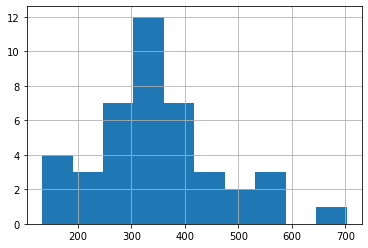

In [53]:
y_target.hist()

<AxesSubplot:>

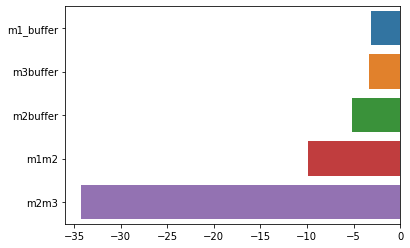

In [54]:
coef=pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values,y=coef_sort.index)

In [55]:
corr = df_3.corr(method = 'pearson')
corr

,m1_buffer,m1m2,m2buffer,m2m3,m3buffer,CycleTime
m1_buffer,1.000000,-0.040955,0.322233,0.084454,0.084715,-0.185327
m1m2,-0.040955,1.000000,0.014815,-0.074195,0.190015,-0.116603
m2buffer,0.322233,0.014815,1.000000,0.044928,-0.388733,-0.132702
m2m3,0.084454,-0.074195,0.044928,1.000000,0.023887,-0.233415
m3buffer,0.084715,0.190015,-0.388733,0.023887,1.000000,0.097658
CycleTime,-0.185327,-0.116603,-0.132702,-0.233415,0.097658,1.000000


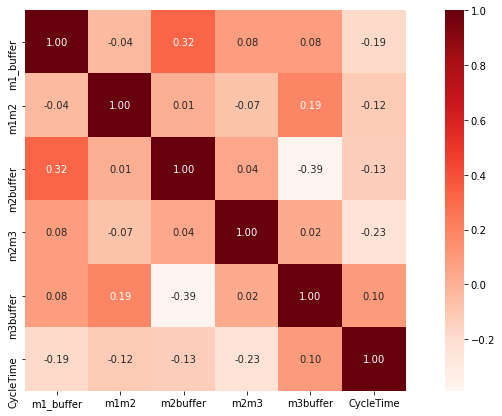

In [56]:
plt.subplots(figsize=(14,7))
df_heatmap = sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 10}, fmt = '.2f', square = True, cmap = 'Reds')

## LightGBM

In [57]:
import lightgbm as lgb

# LightGBM dataSet으로 변환
y_target = df_3['CycleTime']
X_features = df_3.drop(['CycleTime'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

train_LightGBM = lgb.Dataset(X_train, label = y_train) 
test_LightGBM = lgb.Dataset(X_test, label = y_test) 

In [58]:
#파라미터 세팅
params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018}

In [59]:
#학습
model = lgb.train(params, train_LightGBM, 1000, test_LightGBM, verbose_eval=100, early_stopping_rounds=100)

[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 29, number of used features: 0
[LightGBM] [Info] Start training from score 344.206907
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because th

In [60]:
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

In [61]:
mse = mean_squared_error(y_test, predict_test)
r2 = r2_score(y_test, predict_test)

In [62]:
print('Mean squared error: ', mse)
print('R2 score: ', r2)

Mean squared error:  10180.171114721521
R2 score:  -0.0049775424751130615


In [63]:
final_result_LightGBM = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(predict_test)], axis = 1)
final_result_LightGBM.columns = ['label','predict']

<AxesSubplot:xlabel='label', ylabel='predict'>

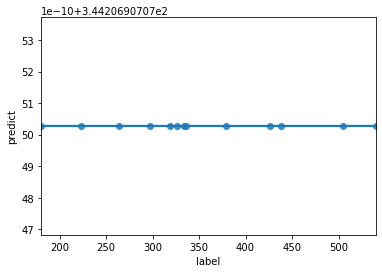

In [64]:
#fit 결과 확인
sns.regplot(x = 'label', y = 'predict', data = final_result_LightGBM)

## Ridge Regression

In [65]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

y_target = df_3['CycleTime']
X_features = df_3.drop(['CycleTime'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
pred=ridge_reg.predict(X_test)

print("훈련 세트의 정확도 : {:.2f}".format(ridge_reg.score(X_train,y_train)))
print("테스트 세트의 정확도 : {:.2f}".format(ridge_reg.score(X_test,y_test)))
evaluate_regr(y_test,pred)

훈련 세트의 정확도 : 0.12
테스트 세트의 정확도 : -0.04
RMSLE: 0.3130262524, RMSE: 102.3961703140, MAE: 81.9309537240


## Lasso Regression

In [66]:
from sklearn.linear_model import Lasso

y_target = df_3['CycleTime']
X_features = df_3.drop(['CycleTime'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)
pred=lasso_reg.predict(X_test)

print("훈련 세트의 정확도 : {:.2f}".format(lasso_reg.score(X_train, y_train)))
print("테스트 세트의 정확도 : {:.2f}".format(lasso_reg.score(X_test, y_test)))
print("사용한 특성의 수 : {}".format(np.sum(lasso_reg.coef_ != 0)))
print("사용한 max_iter : {}".format(lasso_reg.n_iter_))
evaluate_regr(y_test,pred)

훈련 세트의 정확도 : 0.12
테스트 세트의 정확도 : -0.02
사용한 특성의 수 : 5
사용한 max_iter : 11
RMSLE: 0.3112708186, RMSE: 101.8571049853, MAE: 81.5318983578


## Elastic Net

In [67]:
from sklearn.linear_model import ElasticNet

y_target = df_3['CycleTime']
X_features = df_3.drop(['CycleTime'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=0)
elastic_net.fit(X_train, y_train)
pred=elastic_net.predict(X_test)

print("훈련 세트의 정확도 : {:.2f}".format(elastic_net.score(X_train, y_train)))
print("테스트 세트의 정확도 : {:.2f}".format(elastic_net.score(X_test, y_test)))
evaluate_regr(y_test,pred)

훈련 세트의 정확도 : 0.12
테스트 세트의 정확도 : -0.03
RMSLE: 0.3128208502, RMSE: 102.3521878438, MAE: 81.8191298297


In [68]:
pred

array([385.31960574, 353.94252926, 373.1589546 , 360.56603031,
       329.04137159, 381.62825219, 353.90715681, 372.65217356,
       341.49076208, 345.39872379, 374.17148159, 316.59301619,
       254.46018353])

## Decision Tree

In [69]:
from sklearn.tree import DecisionTreeRegressor

y_target = df_3['CycleTime']
X_features = df_3.drop(['CycleTime'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

dt_reg = DecisionTreeRegressor(random_state = 0)
dt_reg.fit(X_train, y_train)
pred = dt_reg.predict(X_test)

evaluate_regr(y_test,pred)

RMSLE: 0.6573571570, RMSE: 179.9474314434, MAE: 141.2307823077


In [70]:
pred

array([554.     , 228.00001, 133.00002, 133.00002, 241.00006, 428.00003,
       133.00002, 241.00006, 312.99997, 171.00003, 133.00002, 241.00006,
       428.00003])

## Random Forest

In [71]:
from sklearn.ensemble import RandomForestRegressor

y_target = df_3['CycleTime']
X_features = df_3.drop(['CycleTime'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

rf_reg = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=150)
rf_reg.fit(X_train, y_train)
pred = rf_reg.predict(X_test)

featureImportance = rf_reg.feature_importances_

evaluate_regr(y_test,pred)

RMSLE: 0.3461437297, RMSE: 117.8289186860, MAE: 84.5568627701


In [72]:
pred

array([324.07636814, 387.63411593, 323.94711792, 300.13926561,
       324.4910101 , 335.87456957, 310.15738463, 294.67725877,
       377.69965835, 261.59262237, 315.50501414, 318.38979154,
       346.14488455])

## SVR

In [73]:
from sklearn.svm import SVR

y_target = df_3['CycleTime']
X_features = df_3.drop(['CycleTime'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

sv_reg = SVR(kernel = 'rbf')
sv_reg.fit(X_train, y_train)
pred = sv_reg.predict(X_test)
#pred = inverse_transform(y_pred)

evaluate_regr(y_test,pred)

RMSLE: 0.3001734420, RMSE: 103.7501200769, MAE: 78.5373149068


In [74]:
X_test.head()

,m1_buffer,m1m2,m2buffer,m2m3,m3buffer
30,6,0,3,0,2
36,5,2,1,1,0
27,4,1,4,0,3
4,6,2,4,0,2
10,5,1,7,1,1


In [75]:
pred

array([325.81240936, 326.43998875, 325.74485794, 325.07347679,
       324.63136268, 326.41759633, 325.14276347, 325.24541069,
       326.6281003 , 325.62639956, 325.88013058, 324.68732699,
       326.18291688])

## 앙상블

## 딥러닝

In [145]:
#데이터를 불러옵니다.
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')


#독립변수와 종속변수를 분리합니다.
#train_X = train.iloc[:,4:]
#train_Y = train.iloc[:,0:4]
#test_X = test.iloc[:,1:]

y_target = df_3['CycleTime']
X_features = df_3.drop(['CycleTime'],axis=1,inplace=False)

X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

#케라스를 통해 모델 생성을 시작합니다.
import keras
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(units=160, activation='relu', input_dim=5))
model.add(Dense(units=160, activation='relu'))
model.add(Dense(units=160, activation='relu'))
model.add(Dense(units=1, activation='linear'))

#모델을 컴파일합니다.
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

#모델을 학습합니다.
model.fit(X_train, y_train, epochs=200, batch_size=10000, validation_split = 0.05)

#예측값을 생성합니다.
pred_test = model.predict(X_test)

#submission 파일을 생성합니다.
#sample_sub = pd.read_csv('sample_submission.csv', index_col=0)
#submission = sample_sub+pred_test
#submission.to_csv('submission.csv')

Using TensorFlow backend.


AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [170]:
y_test = np.reshape(y_test.to_numpy(), (-1, 1))
evaluate_regr(y_test,pred_test)

RMSLE: 0.5156601586, RMSE: 185.8904515474, MAE: 118.9861243112


In [171]:
pred_test

array([[296.2271 ],
       [266.44043],
       [273.7624 ],
       [284.80182],
       [293.44446],
       [212.87964],
       [219.10745],
       [295.4959 ],
       [170.47511],
       [323.72968],
       [296.19537],
       [289.4347 ],
       [259.1271 ],
       [268.64743],
       [291.84744],
       [258.84808],
       [255.07095],
       [260.46146],
       [289.12143],
       [359.18008],
       [286.74918],
       [249.42175],
       [228.72844],
       [306.1446 ],
       [279.90347],
       [330.17126],
       [342.69308],
       [266.6174 ]], dtype=float32)

In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.optimizers import Adam

In [175]:
from keras.layers import Activation, Dropout, BatchNormalization, Input
from keras.layers import *

y_target = df_5['CycleTime']
X_features = df_5.drop(['CycleTime'],axis=1,inplace=False)

X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

In [187]:
model = Sequential()
model.add(Dense(units=768, activation='relu', input_dim=5))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='relu'))

In [192]:
model.compile(loss='mae', optimizer='adam', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=100, batch_size=10000, validation_split = 0.05)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 87.4229 - mae: 87.4229 - val_loss: 257.5831 - val_mae: 257.5831
Epoch 2/100
1/1 [==============================] - 0s 47ms/step - loss: 244.5160 - mae: 244.5160 - val_loss: 198.0572 - val_mae: 198.0572
Epoch 3/100
1/1 [==============================] - 0s 49ms/step - loss: 193.9860 - mae: 193.9860 - val_loss: 237.5402 - val_mae: 237.5402
Epoch 4/100
1/1 [==============================] - 0s 46ms/step - loss: 136.5551 - mae: 136.5551 - val_loss: 260.8007 - val_mae: 260.8007
Epoch 5/100
1/1 [==============================] - 0s 48ms/step - loss: 156.3794 - mae: 156.3794 - val_loss: 158.8375 - val_mae: 158.8375
Epoch 6/100
1/1 [==============================] - 0s 56ms/step - loss: 115.9183 - mae: 115.9183 - val_loss: 147.2184 - val_mae: 147.2184
Epoch 7/100
1/1 [==============================] - 0s 46ms/step - loss: 138.3858 - mae: 138.3858 - val_loss: 136.7678 - val_mae: 136.7678
Epoch 8/100
1/1 [=====================

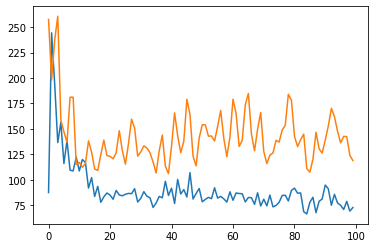

In [193]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [194]:
pred_test = model.predict(X_test)

#sample_sub = pd.read_csv('sample_submission.csv', index_col=0)
#submission = sample_sub+pred_test
#submission.to_csv('baseline_추가.csv')

In [196]:
#y_test = np.reshape(y_test.to_numpy(), (-1, 1))
evaluate_regr(y_test,pred_test)

RMSLE: 0.6374760948, RMSE: 243.4801514679, MAE: 155.4012222290
